In [3]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, constants as cnst, u_arrays, u_darrays, u_met
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.io.shapereader as shapereader
import pickle as pkl
import glob

coast = shapereader.natural_earth(resolution='110m',
                                  category='physical',
                                  name='coastline')

countries = shapereader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [11]:
all_node_file = pkl.load(open(cnst.network_data + 'data/SOMS/saves/node_days.p', "rb"))

In [58]:
nodestr='node'+str(6)
tab = pkl.load(open(cnst.network_data + 'data/SOMS/saves/'+nodestr+'_MCS_matchTable.p', "rb"))

In [59]:
print(tab.lon.max(), tab.lon.min(), tab.lat.max(), tab.lat.min())

12.078850473214825 -16.802247848898475 17.74562661158754 5.19930999908238


In [63]:
fday_mcs = []
for ni in range(1,13):
    nodestr = 'node'+str(ni)
    ndates = all_node_file[nodestr]
    mcs = pkl.load(open(cnst.network_data + 'data/SOMS/saves/'+nodestr+'_MCS_matchTable.p', "rb"))
    shared = np.intersect1d(mcs.index.values, ndates.values)
    fday_mcs.append(float(len(shared)) / float(len(ndates)))

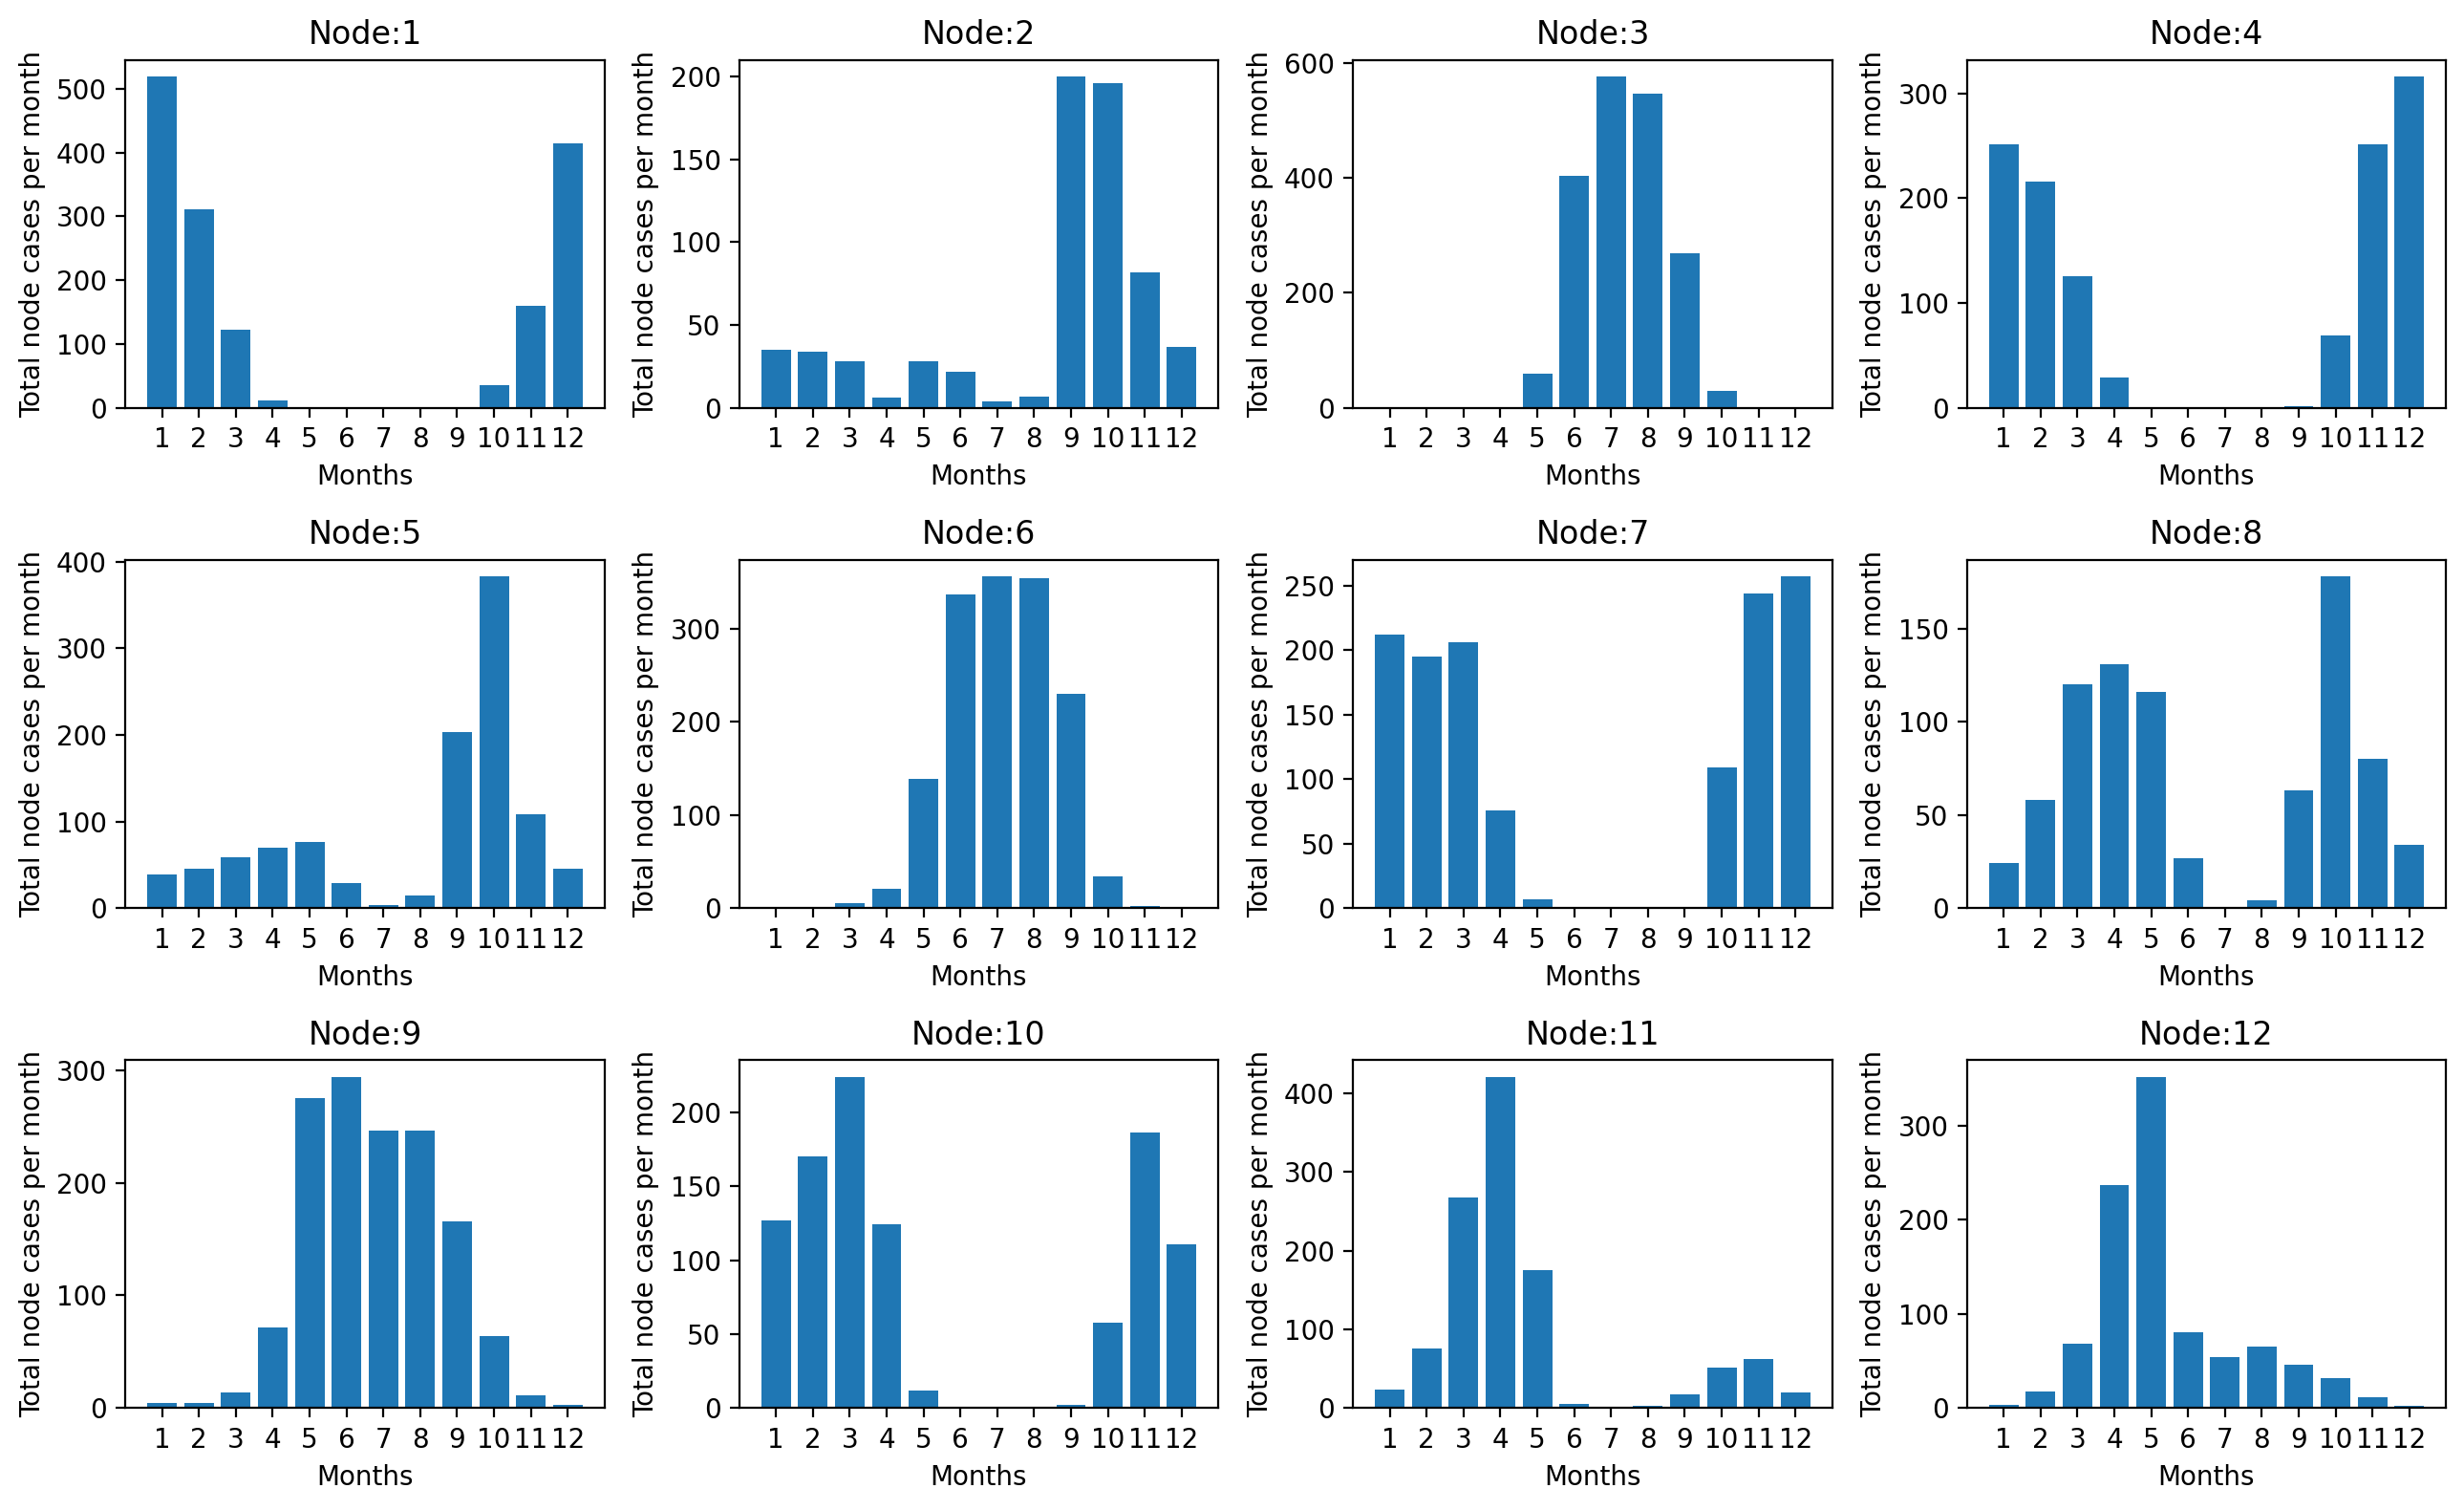

In [61]:

f = plt.figure(figsize=(13,8), dpi=200)
for node in range(1,13):
    nmonth = []
    ax = f.add_subplot(3,4,node)
    nodestr = 'node'+str(node)
    ndates = all_node_file[nodestr]
    for ni in range(1,13):
        nmonth.append(np.sum(ndates.month==ni))
    ax.bar(np.arange(1,13).astype(int), np.array(nmonth))
    ax.set_ylabel('Total node cases per month')
    ax.set_xlabel('Months')
    ax.set_title('Node:'+ str(node))
    ax.set_xticks(np.arange(1,13).astype(int))
    
plt.tight_layout()
f.savefig(cnst.network_data + 'figs/SOMS/nb_node_permonth.jpg')

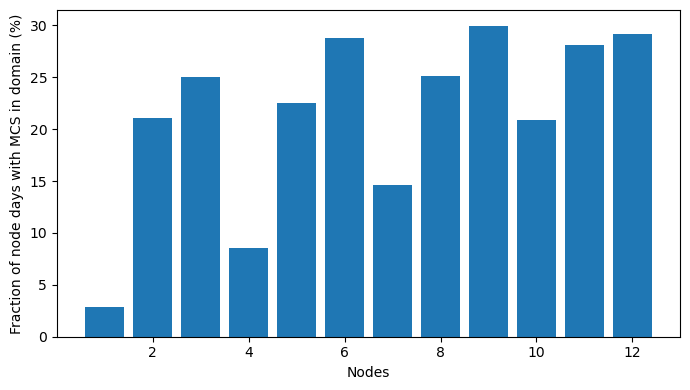

In [70]:
f = plt.figure(figsize=(7,4), dpi=100)
plt.bar(np.arange(1,13), np.array(fday_mcs)*100)
plt.ylabel('Fraction of node days with MCS in domain (%)')
plt.xlabel('Nodes')
plt.tight_layout()
f.savefig(cnst.network_data + 'figs/SOMS/MCS_dayfraction_nodes.jpg')

In [7]:
tab = tab.loc[(tab.lon>box[0]) & (tab.lon<box[1]) & (tab.lat>box[2]) & (tab.lat<box[3])]

In [8]:
len(np.unique(tab.time))

144

In [9]:
def cut_kernel(xpos, ypos, arr, date, lon, lat):

    #AMSRE 0.25 degrees ~ 27.5 km
    dist = 10

    kernel = u_arrays.cut_kernel(arr,xpos, ypos,dist)


    # if (np.sum(np.isfinite(kernel)) < 0.10 * kernel.size):
    #     return

    kernel3 = kernel - np.nanmean(kernel)

    cnt = np.zeros_like(kernel)
    cnt[np.isfinite(kernel)] = 1

    if kernel.shape != (dist*2+1, dist*2+1):
        return None

    return kernel, kernel3, cnt

In [10]:
def run(shift, hh):
    dic = {
    'q' : [],
    'qup' : [],
    't' : [],
    'tup' : [],
    'u' : [],
    'v' : [],
    'w' : [],
    'u_orig' : [],
    'v_orig' : [],        
    'd' : [],
    't2' : [],
    'u100' : [],
    'v100' : [],
    'u100_orig' : [],
    'v100_orig' : [],
    'slp' : [],
    'cnt' : [],
    'cape' : [],
    'divMoist' : [],
    'ice' : [],
    'ice_orig' : [],
   # 'sh' : [],
    'rh' : [],
    'zshear' : [],
    'theta' : []
    }
    
    clim = '/home/ck/DIR/mymachine/ERA5/monthly/synop_selfmade/CLIM_2000-2014/'


    for date in np.unique(tab.time):


        single = tab[tab.time==date]

        dt = pd.to_datetime(date)
        daystring = str(abs(shift))
        dayd = pd.Timedelta(daystring + 'days')
        if shift < 0:
            dt = dt - dayd
        if shift >=0:
            dt = dt + dayd
            
        window1 = dt - pd.Timedelta('14days')
        window2 = dt + pd.Timedelta('14days')
        

        fdate = '_' + str(dt.year) +'_' + str(dt.month).zfill(2) + '_'# + str(dt.day).zfill(2)
        
        hour = hh
        shour = hh

        try:
            era5_files = '/home/ck/DIR/mymachine/ERA5/hourly/' #cnst.ERA5 + 'hourly/
            lsta = xr.open_dataset(era5_files + 'pressure_levels/ERA5' + fdate + 'pl.nc') #sma  #'AMSR_L3_LPRMv05_A_'
            lsta_clim = xr.open_dataset(clim + \
                            'pressure_levels/ERA5_2000-2014_CLIM_' + str(dt.month).zfill(2) + '-'+str(hour).zfill(2)+'_pl.nc')
            
            srfc = xr.open_dataset(era5_files + 'surface/ERA5' + fdate + 'srfc.nc') #sma  #'AMSR_L3_LPRMv05_A_'
            srfc_clim = xr.open_dataset(clim + \
                            'surface/ERA5_2000-2014_CLIM_' + str(dt.month).zfill(2) + '-'+str(hour).zfill(2)+'_srfc.nc')

        except:
            print('File missing', cnst.ERA5  + 'hourly/pressure_levels/ERA5' + fdate + 'pl.nc')
            continue
            
        lsta = u_darrays.flip_lat(lsta)
        srfc = u_darrays.flip_lat(srfc)
        

        lsta = lsta.sel(longitude=slice(-18, 0), latitude=slice(5,17))
        lsta_clim = lsta_clim.sel(lon=slice(-18, 0), lat=slice(5, 17))
        
        srfc = srfc.sel(longitude=slice(-18, 0), latitude=slice(5,17))
        srfc_clim = srfc_clim.sel(lon=slice(-18, 0), lat=slice(5, 17))
        
        pos = np.where(lsta['time.hour']==shour)
        if np.sum(pos) == 0:
            continue
        
        try:
            lsta_low = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00', level=850)
        except:
            continue
        lsta_up = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00', level=500)
        
        srfc_low = srfc.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00')
        
        lsta10 = lsta.isel(time=pos[0])
        lsta10_low = lsta10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'), level=850)
        
        lsta10_up = lsta10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'), level=500)
        
        
        
#         lsta10_low = lsta10.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(shour).zfill(2)+':00:00', level=925)
        
#         lsta10_up = lsta10.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(shour).zfill(2)+':00:00', level=650)
        
        
        
        
        pos = np.where(srfc['time.hour']==shour)
        #ipdb.set_trace()
        srfc10 = srfc.isel(time=pos[0])
        srfc10 = srfc10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'))
     
        
#         srfc10 = srfc.isel(time=pos[0])
#         srfc10 = srfc10.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(shour).zfill(2)+':00:00' )
     
        
        
        
        lsta_clim_low = lsta_clim.sel(level=925)
        lsta_clim_up = lsta_clim.sel(level=650)

        q = lsta_low['q'].squeeze()
        qup = lsta_up['q'].squeeze()
        u = lsta_up['u'].squeeze()
        v = lsta_up['v'].squeeze()
        w = lsta_low['w'].squeeze()
        t = lsta_low['t'].squeeze()
        tup = lsta_up['t'].squeeze()
        d = lsta_low['d'].squeeze()
        rh = lsta_low['r'].squeeze()
        t2 = srfc_low['t2m'].squeeze()
        u100 = srfc_low['u100'].squeeze()
        v100 = srfc_low['v100'].squeeze()
        slp = srfc_low['sp'].squeeze()
        cape = srfc_low['cape'].squeeze()
        divMoist = srfc_low['p84.162'].squeeze()
        ice = srfc_low['tciw'].squeeze()
       # sh = srfc_low['msshf'].squeeze()
        
        q_clim = lsta10_low['q'].squeeze().mean('time')
        qup_clim = lsta10_up['q'].squeeze().mean('time')
        u_clim = lsta10_up['u'].squeeze().mean('time')
        v_clim = lsta10_up['v'].squeeze().mean('time')
        w_clim = lsta10_low['w'].squeeze().mean('time')
        t_clim = lsta10_low['t'].squeeze().mean('time')
        tup_clim = lsta10_up['t'].squeeze().mean('time')
        rh_clim = lsta10_low['r'].squeeze().mean('time')
        d_clim = lsta10_low['d'].squeeze().mean('time')
        t2_clim = srfc10['t2m'].squeeze().mean('time')
        u100_clim = srfc10['u100'].squeeze().mean('time')
        v100_clim = srfc10['v100'].squeeze().mean('time')
        slp_clim = srfc10['sp'].squeeze().mean('time')
        cape_clim = srfc10['cape'].squeeze().mean('time')
        divMoist_clim = srfc10['p84.162'].squeeze().mean('time')
        ice_clim = srfc10['tciw'].squeeze().mean('time')
       # sh_clim = srfc10['msshf'].squeeze().mean('time')
        
#         q_clim = lsta10_low['q'].squeeze()
#         u_clim = lsta10_up['u'].squeeze()
#         v_clim = lsta10_up['v'].squeeze()
#         w_clim = lsta10_low['w'].squeeze()
#         t_clim = lsta10_low['t'].squeeze()
#         rh_clim = lsta10_low['r'].squeeze()
#         d_clim = lsta10_low['d'].squeeze()
#         t2_clim = srfc10['t2m'].squeeze()
#         u100_clim = srfc10['u100'].squeeze()
#         v100_clim = srfc10['v100'].squeeze()
#         slp_clim = srfc10['sp'].squeeze()
#         cape_clim = srfc10['cape'].squeeze()
#         hcc_clim = srfc10['hcc'].squeeze()
#         mcc_clim = srfc10['mcc'].squeeze()
#         divMoist_clim = srfc10['p84.162']
#         ice_clim = srfc10['tciw'].squeeze()
#         sh_clim = srfc10['ishf'].squeeze()

#         q_clim = lsta_clim_low['q'].squeeze()
#         u_clim = lsta_clim_up['u'].squeeze()
#         v_clim = lsta_clim_up['v'].squeeze()
#         t_clim = lsta_clim_low['t'].squeeze()
#         d_clim = lsta_clim_low['d'].squeeze()
#         t2_clim = srfc_clim['t2m'].squeeze()
#         u100_clim = srfc_clim['u100'].squeeze()
#         v100_clim = srfc_clim['v100'].squeeze()
#         slp_clim = srfc_clim['msl'].squeeze()

        print('Doing '+ 'AMSR_' + str(dt.year) + str(dt.month).zfill(2) + str(
        dt.day).zfill(2) + '.nc')
    
        theta_low = u_met.theta_e(925,lsta_low['t'].squeeze().values-273.15,lsta_low['q'].squeeze().values)
        theta_high = u_met.theta_e(700,lsta_up['t'].squeeze().values-273.15,lsta_up['q'].squeeze().values)
        thetadiff = (theta_low-theta_high).squeeze()
        
        theta10_low = u_met.theta_e(925,lsta10_low['t'].squeeze().mean('time').values-273.15,lsta10_low['q'].squeeze().mean('time').values)
        theta10_high = u_met.theta_e(700,lsta10_up['t'].squeeze().mean('time').values-273.15,lsta10_up['q'].squeeze().mean('time').values)
        thetadiff10 = (theta10_low-theta10_high).squeeze()
        
        cnt = np.zeros_like(q.values)
        cnt[np.isfinite(q.values)] = 1

        dic['q'].append(q.values- q_clim.values)
        dic['qup'].append(qup.values- qup_clim.values)
        dic['v'].append(v.values- v_clim.values)
        dic['w'].append(w.values- w_clim.values)
        dic['u'].append(u.values- u_clim.values)
        dic['rh'].append(rh.values- rh_clim.values)
        dic['v_orig'].append(v.values)#
        dic['u_orig'].append(u.values)#
        dic['t'].append(t.values-t_clim.values)
        dic['tup'].append(tup.values-tup_clim.values)
        dic['d'].append(d.values-d_clim.values)
        dic['t2'].append(t2.values-t2_clim.values)
        dic['u100'].append(u100.values-u100_clim.values)
        dic['v100'].append(v100.values-v100_clim.values)
        dic['u100_orig'].append(u100.values)#
        dic['v100_orig'].append(v100.values)#
        dic['slp'].append(slp.values-slp_clim.values)
        dic['cape'].append(cape.values-cape_clim.values)#s-v100_clim.values)
        dic['divMoist'].append(divMoist.values-divMoist_clim.values)#-slp_clim.values)
        dic['ice'].append(ice.values-ice_clim.values)
        dic['ice_orig'].append(ice.values)
       # dic['sh'].append(sh.values-sh_clim.values)
#         ws, wd = u_met.u_v_to_ws_wd(u.values-u100.values, v.values-v100.values)
#         wsclim, wd = u_met.u_v_to_ws_wd(u_clim.values-u100_clim.values, v_clim.values-v100_clim.values)
        dic['zshear'].append((u.values-u100.values)-(u_clim.values-u100_clim.values)) #-wsclim
        dic['theta'].append(thetadiff-thetadiff10)
        dic['cnt'].append(cnt)

        lat = lsta_low.latitude.values
        lon = lsta_low.longitude.values
        
        
    #ipdb.set_trace()
    for k in dic.keys():
        #print(k)
        dic[k] = np.nansum(np.stack(dic[k], axis=0), axis=0)

    return dic, lat, lon

In [11]:
def calc(dic):
    
    dics = {}
    for k in dic.keys():
        if k == 'cnt':
            continue
        dics[k] = dic[k] / dic['cnt']
    return dics

In [12]:
import matplotlib.patches as patches
def draw_map(ax, t, lat, lon, title='', levels=None, quiver=None, contour=None):
   
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), cmap='RdBu', levels=levels, extend='both')
    ax.coastlines()

#     ## quiver list
#     if quiver is not None:
#         qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'],scale=quiver['scale'], width=0.003, headwidth=3.2)
    
    
        ## additional contour on plot   
    contour=None
    if contour is not None:
        contours = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='k', linewidths=2 )
        plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    xl.xlines = False
    xl.ylines=False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');
    
    rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=1,edgecolor='green',facecolor='none', zorder=99)
        
    ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label('g/kg')

In [13]:
box

[-10, -8, 10.5, 11.5]

0
Doing AMSR_20040416.nc
Doing AMSR_20040523.nc
Doing AMSR_20040529.nc
Doing AMSR_20040621.nc
Doing AMSR_20040630.nc
Doing AMSR_20040728.nc
Doing AMSR_20040807.nc
Doing AMSR_20040823.nc
Doing AMSR_20040829.nc
Doing AMSR_20040830.nc
Doing AMSR_20040901.nc
Doing AMSR_20040908.nc
Doing AMSR_20040909.nc
Doing AMSR_20041028.nc
Doing AMSR_20041102.nc
Doing AMSR_20041104.nc
Doing AMSR_20050403.nc
Doing AMSR_20050414.nc
Doing AMSR_20050509.nc
Doing AMSR_20050621.nc
Doing AMSR_20050627.nc
Doing AMSR_20050702.nc
Doing AMSR_20050704.nc
Doing AMSR_20050829.nc
Doing AMSR_20050926.nc
Doing AMSR_20051004.nc
Doing AMSR_20060406.nc
Doing AMSR_20060416.nc
Doing AMSR_20060501.nc
Doing AMSR_20060522.nc
Doing AMSR_20060715.nc
Doing AMSR_20060908.nc
Doing AMSR_20061002.nc
Doing AMSR_20061010.nc
Doing AMSR_20061019.nc
Doing AMSR_20070413.nc
Doing AMSR_20070608.nc
Doing AMSR_20070803.nc
Doing AMSR_20070819.nc
Doing AMSR_20070820.nc
Doing AMSR_20080511.nc
Doing AMSR_20080521.nc
Doing AMSR_20080606.nc
Doing AMS

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Doing AMSR_20040417.nc
Doing AMSR_20040524.nc
Doing AMSR_20040530.nc
Doing AMSR_20040622.nc
Doing AMSR_20040701.nc
Doing AMSR_20040729.nc
Doing AMSR_20040808.nc
Doing AMSR_20040824.nc
Doing AMSR_20040830.nc
Doing AMSR_20040831.nc
Doing AMSR_20040902.nc
Doing AMSR_20040909.nc
Doing AMSR_20040910.nc
Doing AMSR_20041029.nc
Doing AMSR_20041103.nc
Doing AMSR_20041105.nc
Doing AMSR_20050404.nc
Doing AMSR_20050415.nc
Doing AMSR_20050510.nc
Doing AMSR_20050622.nc
Doing AMSR_20050628.nc
Doing AMSR_20050703.nc
Doing AMSR_20050705.nc
Doing AMSR_20050830.nc
Doing AMSR_20050927.nc
Doing AMSR_20051005.nc
Doing AMSR_20060407.nc
Doing AMSR_20060417.nc
Doing AMSR_20060502.nc
Doing AMSR_20060523.nc
Doing AMSR_20060716.nc
Doing AMSR_20060909.nc
Doing AMSR_20061003.nc
Doing AMSR_20061011.nc
Doing AMSR_20061020.nc
Doing AMSR_20070414.nc
Doing AMSR_20070609.nc
Doing AMSR_20070804.nc
Doing AMSR_20070820.nc
Doing AMSR_20070821.nc
Doing AMSR_20080512.nc
Doing AMSR_20080522.nc
Doing AMSR_20080607.nc
Doing AMSR_

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Doing AMSR_20040418.nc
Doing AMSR_20040525.nc
Doing AMSR_20040531.nc
Doing AMSR_20040623.nc
Doing AMSR_20040702.nc
Doing AMSR_20040730.nc
Doing AMSR_20040809.nc
Doing AMSR_20040825.nc
Doing AMSR_20040831.nc
Doing AMSR_20040901.nc
Doing AMSR_20040903.nc
Doing AMSR_20040910.nc
Doing AMSR_20040911.nc
Doing AMSR_20041030.nc
Doing AMSR_20041104.nc
Doing AMSR_20041106.nc
Doing AMSR_20050405.nc
Doing AMSR_20050416.nc
Doing AMSR_20050511.nc
Doing AMSR_20050623.nc
Doing AMSR_20050629.nc
Doing AMSR_20050704.nc
Doing AMSR_20050706.nc
Doing AMSR_20050831.nc
Doing AMSR_20050928.nc
Doing AMSR_20051006.nc
Doing AMSR_20060408.nc
Doing AMSR_20060418.nc
Doing AMSR_20060503.nc
Doing AMSR_20060524.nc
Doing AMSR_20060717.nc
Doing AMSR_20060910.nc
Doing AMSR_20061004.nc
Doing AMSR_20061012.nc
Doing AMSR_20061021.nc
Doing AMSR_20070415.nc
Doing AMSR_20070610.nc
Doing AMSR_20070805.nc
Doing AMSR_20070821.nc
Doing AMSR_20070822.nc
Doing AMSR_20080513.nc
Doing AMSR_20080523.nc
Doing AMSR_20080608.nc
Doing AMSR_

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Doing AMSR_20040419.nc
Doing AMSR_20040526.nc
Doing AMSR_20040601.nc
Doing AMSR_20040624.nc
Doing AMSR_20040703.nc
Doing AMSR_20040731.nc
Doing AMSR_20040810.nc
Doing AMSR_20040826.nc
Doing AMSR_20040901.nc
Doing AMSR_20040902.nc
Doing AMSR_20040904.nc
Doing AMSR_20040911.nc
Doing AMSR_20040912.nc
Doing AMSR_20041031.nc
Doing AMSR_20041105.nc
Doing AMSR_20041107.nc
Doing AMSR_20050406.nc
Doing AMSR_20050417.nc
Doing AMSR_20050512.nc
Doing AMSR_20050624.nc
Doing AMSR_20050630.nc
Doing AMSR_20050705.nc
Doing AMSR_20050707.nc
Doing AMSR_20050901.nc
Doing AMSR_20050929.nc
Doing AMSR_20051007.nc
Doing AMSR_20060409.nc
Doing AMSR_20060419.nc
Doing AMSR_20060504.nc
Doing AMSR_20060525.nc
Doing AMSR_20060718.nc
Doing AMSR_20060911.nc
Doing AMSR_20061005.nc
Doing AMSR_20061013.nc
Doing AMSR_20061022.nc
Doing AMSR_20070416.nc
Doing AMSR_20070611.nc
Doing AMSR_20070806.nc
Doing AMSR_20070822.nc
Doing AMSR_20070823.nc
Doing AMSR_20080514.nc
Doing AMSR_20080524.nc
Doing AMSR_20080609.nc
Doing AMSR_

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Doing AMSR_20040416.nc
Doing AMSR_20040523.nc
Doing AMSR_20040529.nc
Doing AMSR_20040621.nc
Doing AMSR_20040630.nc
Doing AMSR_20040728.nc
Doing AMSR_20040807.nc
Doing AMSR_20040823.nc
Doing AMSR_20040829.nc
Doing AMSR_20040830.nc
Doing AMSR_20040901.nc
Doing AMSR_20040908.nc
Doing AMSR_20040909.nc
Doing AMSR_20041028.nc
Doing AMSR_20041102.nc
Doing AMSR_20041104.nc
Doing AMSR_20050403.nc
Doing AMSR_20050414.nc
Doing AMSR_20050509.nc
Doing AMSR_20050621.nc
Doing AMSR_20050627.nc
Doing AMSR_20050702.nc
Doing AMSR_20050704.nc
Doing AMSR_20050829.nc
Doing AMSR_20050926.nc
Doing AMSR_20051004.nc
Doing AMSR_20060406.nc
Doing AMSR_20060416.nc
Doing AMSR_20060501.nc
Doing AMSR_20060522.nc
Doing AMSR_20060715.nc
Doing AMSR_20060908.nc
Doing AMSR_20061002.nc
Doing AMSR_20061010.nc
Doing AMSR_20061019.nc
Doing AMSR_20070413.nc
Doing AMSR_20070608.nc
Doing AMSR_20070803.nc
Doing AMSR_20070819.nc
Doing AMSR_20070820.nc
Doing AMSR_20080511.nc
Doing AMSR_20080521.nc
Doing AMSR_20080606.nc
Doing AMSR_

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Doing AMSR_20040417.nc
Doing AMSR_20040524.nc
Doing AMSR_20040530.nc
Doing AMSR_20040622.nc
Doing AMSR_20040701.nc
Doing AMSR_20040729.nc
Doing AMSR_20040808.nc
Doing AMSR_20040824.nc
Doing AMSR_20040830.nc
Doing AMSR_20040831.nc
Doing AMSR_20040902.nc
Doing AMSR_20040909.nc
Doing AMSR_20040910.nc
Doing AMSR_20041029.nc
Doing AMSR_20041103.nc
Doing AMSR_20041105.nc
Doing AMSR_20050404.nc
Doing AMSR_20050415.nc
Doing AMSR_20050510.nc
Doing AMSR_20050622.nc
Doing AMSR_20050628.nc
Doing AMSR_20050703.nc
Doing AMSR_20050705.nc
Doing AMSR_20050830.nc
Doing AMSR_20050927.nc
Doing AMSR_20051005.nc
Doing AMSR_20060407.nc
Doing AMSR_20060417.nc
Doing AMSR_20060502.nc
Doing AMSR_20060523.nc
Doing AMSR_20060716.nc
Doing AMSR_20060909.nc
Doing AMSR_20061003.nc
Doing AMSR_20061011.nc
Doing AMSR_20061020.nc
Doing AMSR_20070414.nc
Doing AMSR_20070609.nc
Doing AMSR_20070804.nc
Doing AMSR_20070820.nc
Doing AMSR_20070821.nc
Doing AMSR_20080512.nc
Doing AMSR_20080522.nc
Doing AMSR_20080607.nc
Doing AMSR_

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Doing AMSR_20040418.nc
Doing AMSR_20040525.nc
Doing AMSR_20040531.nc
Doing AMSR_20040623.nc
Doing AMSR_20040702.nc
Doing AMSR_20040730.nc
Doing AMSR_20040809.nc
Doing AMSR_20040825.nc
Doing AMSR_20040831.nc
Doing AMSR_20040901.nc
Doing AMSR_20040903.nc
Doing AMSR_20040910.nc
Doing AMSR_20040911.nc
Doing AMSR_20041030.nc
Doing AMSR_20041104.nc
Doing AMSR_20041106.nc
Doing AMSR_20050405.nc
Doing AMSR_20050416.nc
Doing AMSR_20050511.nc
Doing AMSR_20050623.nc
Doing AMSR_20050629.nc
Doing AMSR_20050704.nc
Doing AMSR_20050706.nc
Doing AMSR_20050831.nc
Doing AMSR_20050928.nc
Doing AMSR_20051006.nc
Doing AMSR_20060408.nc
Doing AMSR_20060418.nc
Doing AMSR_20060503.nc
Doing AMSR_20060524.nc
Doing AMSR_20060717.nc
Doing AMSR_20060910.nc
Doing AMSR_20061004.nc
Doing AMSR_20061012.nc
Doing AMSR_20061021.nc
Doing AMSR_20070415.nc
Doing AMSR_20070610.nc
Doing AMSR_20070805.nc
Doing AMSR_20070821.nc
Doing AMSR_20070822.nc
Doing AMSR_20080513.nc
Doing AMSR_20080523.nc
Doing AMSR_20080608.nc
Doing AMSR_

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Doing AMSR_20040419.nc
Doing AMSR_20040526.nc
Doing AMSR_20040601.nc
Doing AMSR_20040624.nc
Doing AMSR_20040703.nc
Doing AMSR_20040731.nc
Doing AMSR_20040810.nc
Doing AMSR_20040826.nc
Doing AMSR_20040901.nc
Doing AMSR_20040902.nc
Doing AMSR_20040904.nc
Doing AMSR_20040911.nc
Doing AMSR_20040912.nc
Doing AMSR_20041031.nc
Doing AMSR_20041105.nc
Doing AMSR_20041107.nc
Doing AMSR_20050406.nc
Doing AMSR_20050417.nc
Doing AMSR_20050512.nc
Doing AMSR_20050624.nc
Doing AMSR_20050630.nc
Doing AMSR_20050705.nc
Doing AMSR_20050707.nc
Doing AMSR_20050901.nc
Doing AMSR_20050929.nc
Doing AMSR_20051007.nc
Doing AMSR_20060409.nc
Doing AMSR_20060419.nc
Doing AMSR_20060504.nc
Doing AMSR_20060525.nc
Doing AMSR_20060718.nc
Doing AMSR_20060911.nc
Doing AMSR_20061005.nc
Doing AMSR_20061013.nc
Doing AMSR_20061022.nc
Doing AMSR_20070416.nc
Doing AMSR_20070611.nc
Doing AMSR_20070806.nc
Doing AMSR_20070822.nc
Doing AMSR_20070823.nc
Doing AMSR_20080514.nc
Doing AMSR_20080524.nc
Doing AMSR_20080609.nc
Doing AMSR_

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


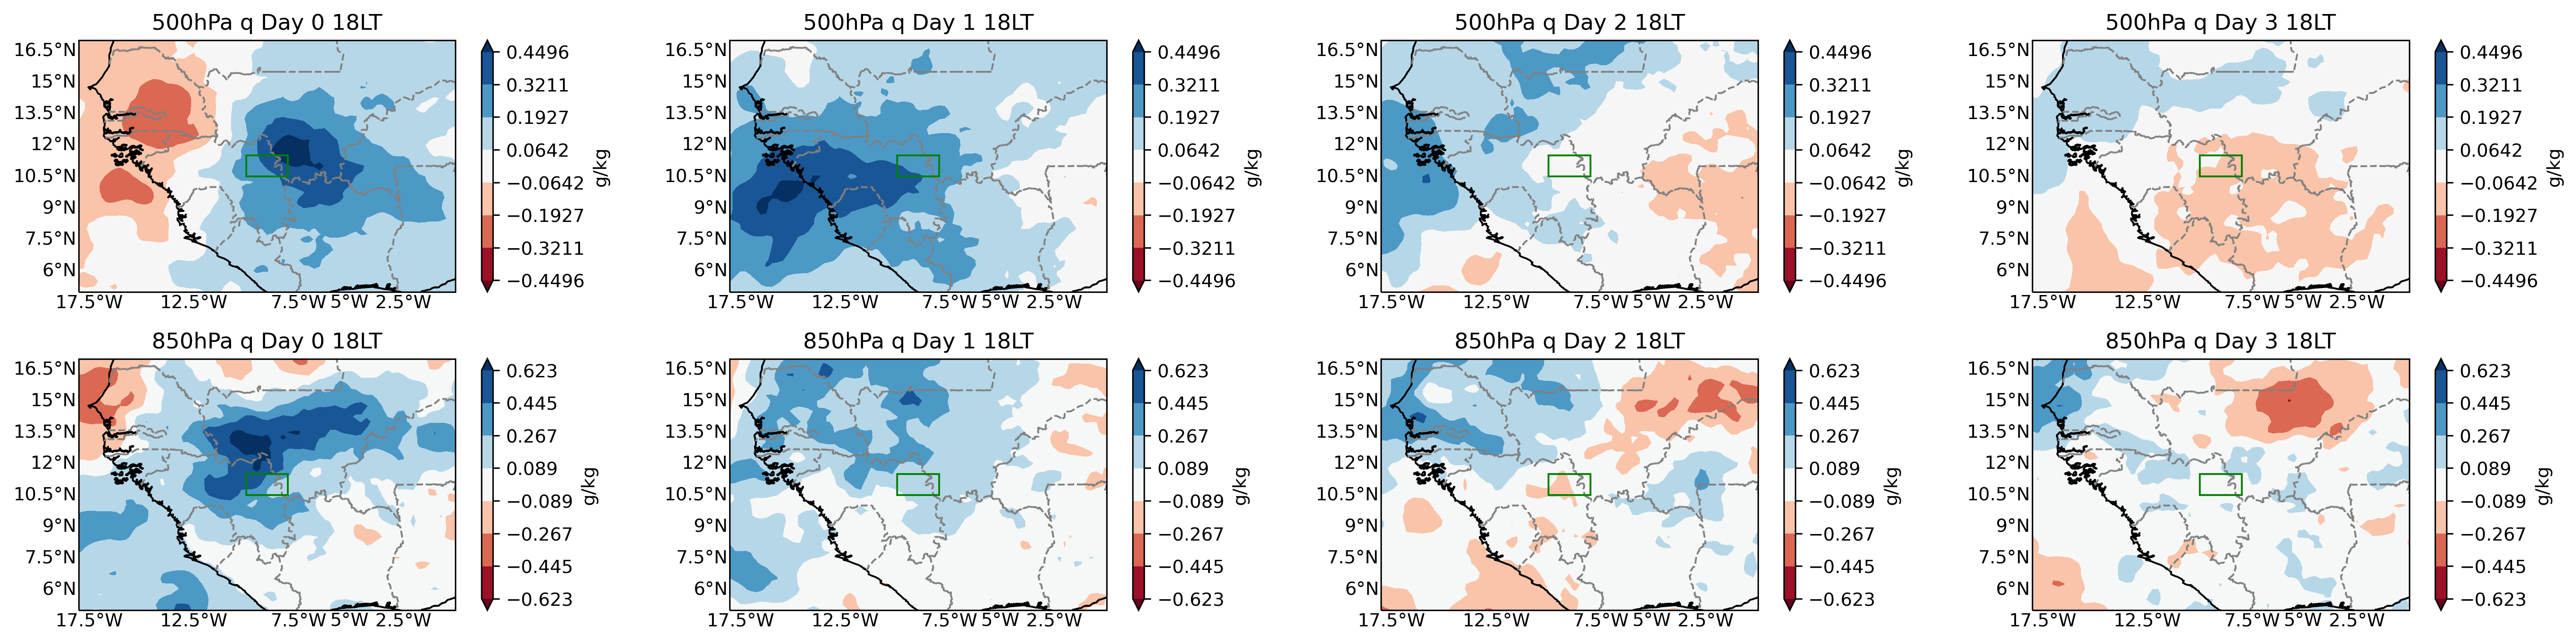

In [16]:
st=2
sarrow = 2
scale = 30
utag = 'u100'
vtag = 'v100'

f = plt.figure(figsize=(20,5), dpi=300)

hours_pick = [18,18,18,18]
for ids, num in enumerate([0, 1,2,3]):

    ax = f.add_subplot(2,4,ids+1, projection=ccrs.PlateCarree())
    print(num)
    dic, lat, lon = run(num, hours_pick[ids])
    dic = calc(dic)
    
    if ids == 0:
        lon2d, lat2d = np.meshgrid(lon,lat)
        xquiv = lon2d[sarrow::st, sarrow::st]
        yquiv = lat2d[sarrow::st, sarrow::st]
    #ipdb.set_trace()
    
    ws, wd = u_met.u_v_to_ws_wd(dic['u_orig']-dic['u100_orig'], dic['v_orig']-dic['v100_orig'])
    vart = 'qup'
    var = dic[vart]*1000
    
    if ids == 0:
        edge = np.max([np.abs(np.percentile(var,1)),np.abs(np.percentile(var,99))])
        lev = np.linspace(edge*-1,edge,8) # edge*-1
    #ipdb.set_trace()
    u = dic[utag]
    v = dic[vtag]

    uu = u[sarrow::st, sarrow::st]
    vv = v[sarrow::st, sarrow::st]
    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : scale}
    
     
    if vart == 'q':
        vtags = '850hPa q'
    if vart == 'qup':
        vtags = '500hPa q'
    
    cvar = 'cape'
    invar = dic[cvar]
    if ids == 0:
        edge = np.max([np.abs(np.percentile(invar,5)),np.abs(np.percentile(invar,95))])
        levs = np.linspace(edge*-1,edge,4) # edge*-1
    contour = {'data' : invar, 'x' : lon, 'y' : lat, 'levels' : levs}
    
    draw_map(ax, var, lat, lon, title=vtags+' Day '+str(num)+' '+str(hours_pick[ids])+'LT',  quiver=qin, levels=lev, contour=contour)  #levels=lev,
    
    
for ids, num in enumerate([0, 1,2,3]):
    

    ax = f.add_subplot(2,4,ids+1+4, projection=ccrs.PlateCarree())
    print(num)
    dic, lat, lon = run(num, hours_pick[ids])
    dic = calc(dic)
    
    if ids == 0:
        lon2d, lat2d = np.meshgrid(lon,lat)
        xquiv = lon2d[sarrow::st, sarrow::st]
        yquiv = lat2d[sarrow::st, sarrow::st]
    #ipdb.set_trace()
    
    ws, wd = u_met.u_v_to_ws_wd(dic['u_orig']-dic['u100_orig'], dic['v_orig']-dic['v100_orig'])
    vart = 'q'
    var = dic[vart]*1000
    
    if ids == 0:
        edge = np.max([np.abs(np.percentile(var,1)),np.abs(np.percentile(var,99))])
        lev = np.linspace(edge*-1,edge,8) # edge*-1
    #ipdb.set_trace()
    u = dic[utag]
    v = dic[vtag]

    uu = u[sarrow::st, sarrow::st]
    vv = v[sarrow::st, sarrow::st]
    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : scale}
    
    
    cvar = 'cape'
    invar = dic[cvar]
    if ids == 0:
        edge = np.max([np.abs(np.percentile(invar,5)),np.abs(np.percentile(invar,95))])
        levs = np.linspace(edge*-1,edge,4) # edge*-1
    contour = {'data' : invar, 'x' : lon, 'y' : lat, 'levels' : levs}
    
    if vart == 'q':
        vtags = '850hPa q'
    if vart == 'qup':
        vtags = '500hPa q'
    
    draw_map(ax, var, lat, lon, title=vtags+' Day '+str(num)+' '+str(hours_pick[ids])+'LT',  quiver=qin, levels=lev, contour=contour)  #levels=lev,

f.canvas.draw()
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/NFLICS/plots/cb_same/NFLICS_ERA5anomaly_dakarstorms_anom_q_days+2_11-12N.jpg')